# Project1 Classification Analysis on Textual Data

## Problem A

Load Files

In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

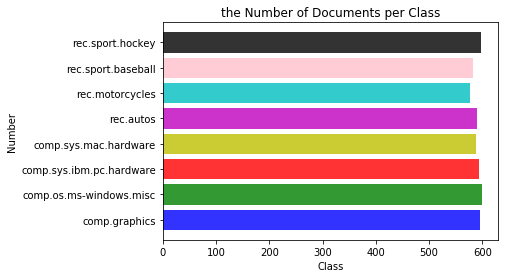

In [2]:
import matplotlib.pyplot as plt

value = {}
for i in train.target:
    if i not in value:
        value[i] = 0
    else:
        value[i] += 1
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['b','g','r','y','m','c','pink','k']
plt.barh(train.target_names, list(value.values()),alpha=0.8, color=colors)
plt.xlabel('Class')
plt.ylabel('Number')
plt.title('the Number of Documents per Class')
plt.show()

## Problem B

First tokenize each document into words.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(min_df=1)
train_counts = count_vectorizer.fit_transform(train.data)
train_counts.shape

(4732, 79218)

Then, excluding the stop words, punctuations, and using stemmed version of words, create a TFxIDF vector representations.

In [4]:
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
import string,re

def stemming_tokenizer(text):
    stemmer = SnowballStemmer("english")
    text = "".join([a for a in text if a not in string.punctuation]) # remove all punctuation
    text = re.sub('[,.-:/()?{}*$#&]',' ', text) # remove all symbols
    text = "".join(b for b in text if ord(b) < 128) # remove all non-ascii characters
    words = text.split()
    stemmed = [stemmer.stem(item) for item in words]
    return stemmed

stop_words = text.ENGLISH_STOP_WORDS

count_vect_final = CountVectorizer(analyzer='word' , tokenizer=stemming_tokenizer, stop_words=stop_words, min_df=4, max_df =0.99)
train_counts_final = count_vect_final.fit_transform(train.data)

count_vect_2 = CountVectorizer(analyzer='word' , tokenizer=stemming_tokenizer, stop_words=stop_words, min_df=2, max_df =0.99)
train_counts_2 = count_vect_2.fit_transform(train.data)

count_vect_5 = CountVectorizer(analyzer='word' , tokenizer=stemming_tokenizer, stop_words=stop_words, min_df=5, max_df =0.99)
train_counts_5 = count_vect_5.fit_transform(train.data)

print ("Number of terms Extracted : " + str(train_counts_final.shape[1]))
print ("Number of terms Extracted if mid_df=2: " + str(train_counts_2.shape[1]))
print ("Number of terms Extracted if mid_df=5: " + str(train_counts_5.shape[1]))

Number of terms Extracted : 10741
Number of terms Extracted if mid_df=2: 21793
Number of terms Extracted if mid_df=5: 8816


TFxIDF

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_train = tfidf_transformer.fit_transform(train_counts_final)
tfidf_train.shape

(4732, 10741)

## Problem C

Find the 10 most significant terms in each of the following classes with respect to TFxICF measure.

TF -- the term frequency in a class

In [6]:
all_categories = ['comp.graphics',
                'comp.os.ms-windows.misc',
                'comp.sys.ibm.pc.hardware',
                'comp.sys.mac.hardware',
                'comp.windows.x',
                'rec.autos',
                'rec.motorcycles',
                'rec.sport.baseball',
                'rec.sport.hockey',
                'alt.atheism',
                'sci.crypt',
                'sci.electronics',
                'sci.med',
                'sci.space',
                'soc.religion.christian',
                'misc.forsale',
                'talk.politics.guns',
                'talk.politics.mideast',
                'talk.politics.misc',
                'talk.religion.misc'
                ]

all_docs_per_category = []
for cate in all_categories:
    category_data = fetch_20newsgroups(subset='train',categories=[cate]).data
    temp = ""
    for doc in category_data:
        temp = temp + " "+ doc
    all_docs_per_category.append(temp)
    
vectorizer = CountVectorizer(analyzer='word',stop_words=stop_words, tokenizer=stemming_tokenizer)
vectorized_newsgroups_train = vectorizer.fit_transform(all_docs_per_category)
vectorized_newsgroups_train.shape

(20, 111882)

Calculate the TFxICF

In [7]:
tficf_train = tfidf_transformer.fit_transform(vectorized_newsgroups_train)

Find the 10 most significant terms

In [8]:
import numpy as np

tficf_train_copy = tficf_train.copy()
features = vectorizer.get_feature_names()
for i in [2, 3, 14, 15]:
    temp = []
    for j in range(10):
        temp.append(features[np.argmax(tficf_train_copy[i])])
        tficf_train_copy[i, np.argmax(tficf_train_copy[i])] = 0
    print(all_categories[i],temp)

comp.sys.ibm.pc.hardware ['scsi', 'drive', 'ide', 'use', 'line', 'subject', 'organ', 'card', 'control', 'mb']
comp.sys.mac.hardware ['line', 'mac', 'subject', 'organ', 'use', 'quadra', 'simm', 'appl', 'scsi', 'problem']
soc.religion.christian ['god', 'christian', 'jesus', 'church', 'subject', 'peopl', 'line', 'say', 'christ', 'believ']
misc.forsale ['line', 'subject', 'sale', 'organ', 'univers', 'new', 'use', 'offer', 'dos', 'nntppostinghost']


## Problem D

Apply **LSI** to TFxIDF matrix corresponding to the 8 classes, and pick k=50.

In [9]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=50, random_state=42)
transformed_tfidf = SVD.fit_transform(tfidf_train)
print("Dimensions of TF-IDF vector after LSI: "+ str(transformed_tfidf.shape))

Dimensions of TF-IDF vector after LSI: (4732, 50)


Alternatively, reduce dimensionality through Non-Negeative Matrix Factorization(**NMF**), and pick k=50.

In [10]:
from sklearn.decomposition import NMF

trainNMF = NMF(n_components=50, init='random', random_state=42)
NMFed_train = trainNMF.fit_transform(tfidf_train)
NMFed_train.shape

(4732, 50)

## Problem E

### Use hard margin SVM classifer (SVC) to separate the documents into 'Computer Technology' vs 'Recreational Activity' groups.

Build a hard margin SVM classifier(SVC)

In [11]:
from sklearn import svm
hard_classifier = svm.LinearSVC(C=1000 ,dual=False, random_state=42)
train_targets = []# bigger than or equal to 4 belongs to recreational activity  
for i in train.target:
    if i >= 4:
        train_targets.append(1)
    else:
        train_targets.append(0)
        
hard_classifier.fit(transformed_tfidf, train_targets)#train the classifier

LinearSVC(C=1000, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Preparing the test data

In [12]:
test = fetch_20newsgroups(subset="test", categories=categories, shuffle=True, random_state=42)
test_counts = count_vect_final.fit_transform(test.data)#using the train CountVectorizer
tfidf_test = tfidf_transformer.fit_transform(test_counts)#using the train TfidfTransformer
transformed_test_tfidf = SVD.fit_transform(tfidf_test)#using the train TruncatedSVD

test_targets = []# bigger than or equal to 4 belongs to recreational activity  
for i in test.target:
    if i >= 4:
        test_targets.append(1)
    else:
        test_targets.append(0)

Predict the test data

In [13]:
predicted = hard_classifier.predict(transformed_test_tfidf)

plot the ROC curve, report the confusion matrix and calculate the accuracy, recall and precision of classifier.

Accuracy of Hard Margin SVM: 0.873968253968
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.88      0.86      0.87      1560
Recreational activity       0.87      0.89      0.88      1590

          avg / total       0.87      0.87      0.87      3150

------------------------------------------------------------
Confusion Matrix: 
[[1345  215]
 [ 182 1408]]
------------------------------------------------------------


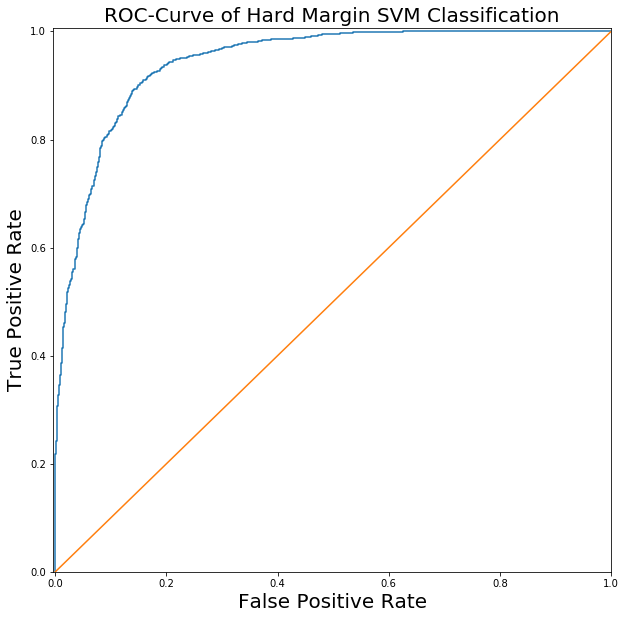

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

score = hard_classifier.decision_function(transformed_test_tfidf)
accuracy = np.mean(predicted == test_targets)
# Report results
print("Accuracy of Hard Margin SVM: " + str(accuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, predicted, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, predicted))
print("-"*60)

fpr, tpr, threshold = roc_curve(test_targets, score)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of Hard Margin SVM Classification', fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()

### Use soft margin SVM classifer to separate the documents into 'Computer Technology' vs 'Recreational Activity' groups.

In [15]:
soft_classifier = svm.LinearSVC( C=0.001 ,dual=False, random_state=42)
soft_classifier.fit(transformed_tfidf, train_targets)

LinearSVC(C=0.001, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Accuracy of soft margin Linear SVM: 0.925079365079
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.97      0.88      0.92      1560
Recreational activity       0.89      0.97      0.93      1590

          avg / total       0.93      0.93      0.92      3150

------------------------------------------------------------
Confusion Matrix: 
[[1370  190]
 [  46 1544]]
------------------------------------------------------------


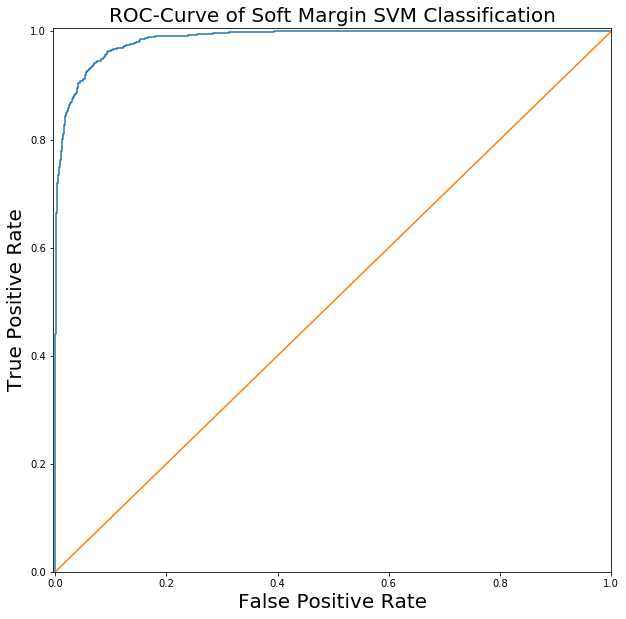

In [16]:
predicted_soft = soft_classifier.predict(transformed_test_tfidf)
score_soft = soft_classifier.decision_function(transformed_test_tfidf)
accuracy_soft = np.mean(predicted_soft == test_targets)
# Report results
print("Accuracy of soft margin Linear SVM: " + str(accuracy_soft))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, predicted_soft, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, predicted_soft))
print("-"*60)

fpr_soft, tpr_soft, threshold_soft = roc_curve(test_targets, score_soft)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(fpr_soft, tpr_soft)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of Soft Margin SVM Classification', fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()

###  Alternatively，classify documents using NMF to reduce dimensionality  

Passing：May be completed later

## Problem F

Using a 5-fold cross_validation, find the best value of the parameter $ \gamma $ in the range  $ \left \{ 10^k \mid -3 \leq k \leq 3, k \in Z \right \} $

In [17]:
from sklearn.model_selection import cross_val_score

best_score = 0
best_gamma = 0
for gamma_value in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    classifier = svm.LinearSVC(C=gamma_value, dual=False, random_state=42)
    classifier.fit(transformed_tfidf, train_targets)
    scores = (cross_val_score(classifier, transformed_tfidf, train_targets, cv=5))
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_gamma = gamma_value
    
    print("Accuracy: %0.8f (+/- %0.8f)" % (scores.mean(), scores.std() * 2)) # But I really don't know what is the best gamma stand for...

print("Best Accuracy is %0.8f obtained for gamma = " % best_score + str(best_gamma))      

Accuracy: 0.94674847 (+/- 0.00886187)
Accuracy: 0.96619121 (+/- 0.01106256)
Accuracy: 0.96999537 (+/- 0.01415634)
Accuracy: 0.97591079 (+/- 0.00815218)
Accuracy: 0.97675623 (+/- 0.00692097)
Accuracy: 0.97612198 (+/- 0.00687109)
Accuracy: 0.97633340 (+/- 0.00817760)
Best Accuracy is 0.97675623 obtained for gamma = 10


Accuracy of Linear SVM using gamma=10 : 0.87873015873
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.88      0.87      0.88      1560
Recreational activity       0.88      0.88      0.88      1590

          avg / total       0.88      0.88      0.88      3150

------------------------------------------------------------
Confusion Matrix: 
[[1362  198]
 [ 184 1406]]
------------------------------------------------------------


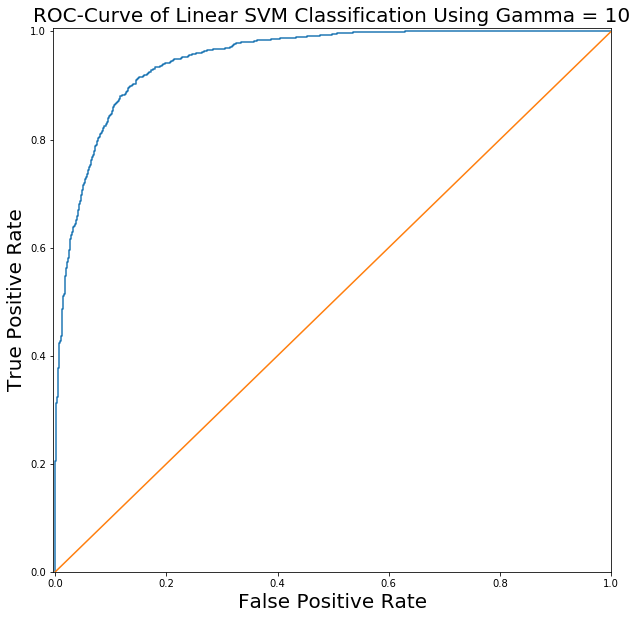

In [18]:
bestclassifier = svm.LinearSVC(C=best_gamma, dual=False, random_state=42)
bestclassifier.fit(transformed_tfidf, train_targets)
prediction = bestclassifier.predict(transformed_test_tfidf)
onescore = bestclassifier.decision_function(transformed_test_tfidf)
oneaccuracy = np.mean(prediction == test_targets)
# Report results
print("Accuracy of Linear SVM using gamma=%s : " % best_gamma + str(oneaccuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, prediction, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, prediction))
print("-"*60)

onefpr, onetpr, onethreshold = roc_curve(test_targets, onescore)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(onefpr, onetpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of Linear SVM Classification Using Gamma = '+ str(best_gamma), fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()


## Problem G

Using Naïve Bayes algorithm for the same classification task

Train a multinomial naïve Bayes classifier and plot the ROC curve for different values of the threshold on
class probabilities. 

Accuracy of multinomial naïve Bayes: 0.846984126984
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.99      0.70      0.82      1560
Recreational activity       0.77      0.99      0.87      1590

          avg / total       0.88      0.85      0.84      3150

------------------------------------------------------------
Confusion Matrix: 
[[1087  473]
 [   9 1581]]
------------------------------------------------------------


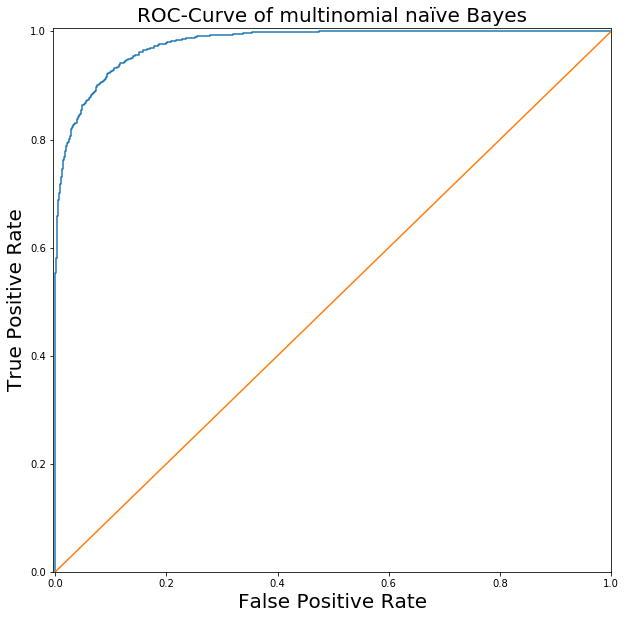

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
scaled_tfidf= min_max_scaler.fit_transform(transformed_tfidf)
scaled_test_tfidf = min_max_scaler.fit_transform(transformed_test_tfidf)

NB = MultinomialNB()
NB.fit(scaled_tfidf, train_targets)
NBprediction = NB.predict(scaled_test_tfidf)
NBaccuracy = np.mean(NBprediction == test_targets)
predict_probability = NB.predict_proba(scaled_test_tfidf[:])[:,1]

# Report results
print("Accuracy of multinomial naïve Bayes: " + str(NBaccuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, NBprediction, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, NBprediction))
print("-"*60)

NBfpr, NBtpr, NBthreshold = roc_curve(test_targets, predict_probability)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(NBfpr, NBtpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of multinomial naïve Bayes', fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()

## Problem H

Repeat the same task with the logistic regression classifier, and plot the ROC curve for different
values of the threshold on class probabilities.

Accuracy of logistic regression classifier: 0.916507936508
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.92      0.91      0.92      1560
Recreational activity       0.92      0.92      0.92      1590

          avg / total       0.92      0.92      0.92      3150

------------------------------------------------------------
Confusion Matrix: 
[[1426  134]
 [ 129 1461]]
------------------------------------------------------------


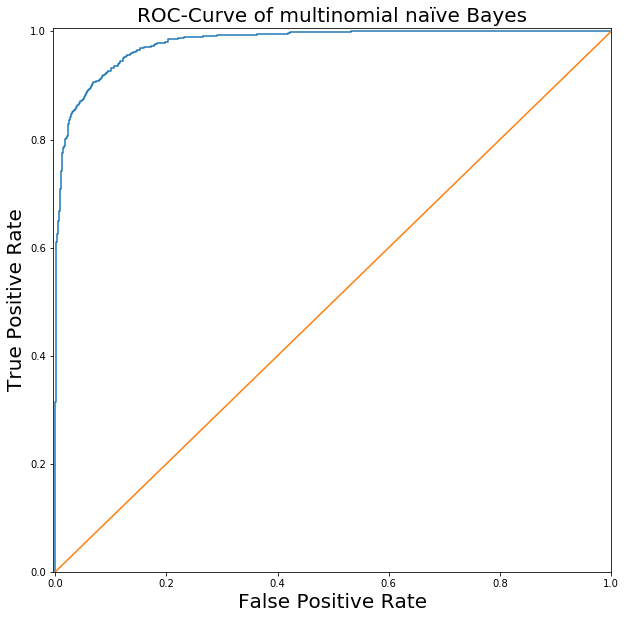

In [20]:
from sklearn.linear_model import LogisticRegression

logclassifier = LogisticRegression()
logclassifier.fit(transformed_tfidf, train_targets)
logprediction = logclassifier.predict(transformed_test_tfidf)
logaccuracy = np.mean(logprediction == test_targets)
logpredict_probability = logclassifier.predict_proba(transformed_test_tfidf[:])[:,1]

# Report results
print("Accuracy of logistic regression classifier: " + str(logaccuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, logprediction, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, logprediction))
print("-"*60)

logfpr, logtpr, logthreshold = roc_curve(test_targets, logpredict_probability)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(logfpr,logtpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of multinomial naïve Bayes', fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()

## Problem I

Repeat part (h) by adding a regularization term to the optimization objective. Try both $l_1$ and $l_2$
norm regularizations and sweep through different regularization coefficients, ranging from very small
ones to large ones

$l_1$ norm regularizations 

In [25]:
c = [0.001,0.1,10,1000,1e5]

for c_value in c:
    log1 = LogisticRegression(C = c_value, penalty = 'l1')
    log1.fit(transformed_tfidf,train_targets)
    logpredict1 = log1.predict(transformed_test_tfidf)
    
    print("l1 Logistic regression: c = {}, accuracy = {}, coeff[0] = {:0.5f}".format(c_value, np.mean(logpredict1 == test_targets),log1.coef_[0][0]))
    print("Classification report: ")
    print(classification_report(test_targets, logpredict1, target_names=['Computer technology', 'Recreational activity']))
    print("Confusion Matrix: ")
    print(confusion_matrix(test_targets, logpredict1))
    print("="*60)

l1 Logistic regression: c = 0.001, accuracy = 0.49523809523809526, coeff[0] = 0.00000
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.50      1.00      0.66      1560
Recreational activity       0.00      0.00      0.00      1590

          avg / total       0.25      0.50      0.33      3150

Confusion Matrix: 
[[1560    0]
 [1590    0]]
l1 Logistic regression: c = 0.1, accuracy = 0.9158730158730158, coeff[0] = 0.00000
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.90      0.94      0.92      1560
Recreational activity       0.94      0.89      0.91      1590

          avg / total       0.92      0.92      0.92      3150

Confusion Matrix: 
[[1467   93]
 [ 172 1418]]
l1 Logistic regression: c = 10, accuracy = 0.8812698412698413, coeff[0] = -6.99587
Classification report: 
                       precision    recall  f1-score   support

  Computer

C:\Users\sikas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


l1 Logistic regression: c = 1000, accuracy = 0.8736507936507937, coeff[0] = -8.81360
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.88      0.86      0.87      1560
Recreational activity       0.87      0.89      0.88      1590

          avg / total       0.87      0.87      0.87      3150

Confusion Matrix: 
[[1341  219]
 [ 179 1411]]
l1 Logistic regression: c = 100000.0, accuracy = 0.873015873015873, coeff[0] = -8.85154
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.88      0.86      0.87      1560
Recreational activity       0.87      0.89      0.88      1590

          avg / total       0.87      0.87      0.87      3150

Confusion Matrix: 
[[1340  220]
 [ 180 1410]]


$l_2$ norm regularizations 

In [27]:
for c_value in c:
    log2 = LogisticRegression(C = c_value, penalty = 'l2')
    log2.fit(transformed_tfidf,train_targets)
    logpredict2 = log2.predict(transformed_test_tfidf)
    
    print("l2 Logistic regression: c = {}, accuracy = {}, coeff[0] = {:0.5f}".format(c_value, np.mean(logpredict2 == test_targets),log2.coef_[0][0]))
    print("Classification report: ")
    print(classification_report(test_targets, logpredict2, target_names=['Computer technology', 'Recreational activity']))
    print("Confusion Matrix: ")
    print(confusion_matrix(test_targets, logpredict2))
    print("="*60)

l2 Logistic regression: c = 0.001, accuracy = 0.7885714285714286, coeff[0] = -0.02271
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       1.00      0.57      0.73      1560
Recreational activity       0.70      1.00      0.83      1590

          avg / total       0.85      0.79      0.78      3150

Confusion Matrix: 
[[ 894  666]
 [   0 1590]]
l2 Logistic regression: c = 0.1, accuracy = 0.9304761904761905, coeff[0] = -1.28118
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.94      0.92      0.93      1560
Recreational activity       0.92      0.94      0.93      1590

          avg / total       0.93      0.93      0.93      3150

Confusion Matrix: 
[[1439  121]
 [  98 1492]]
l2 Logistic regression: c = 10, accuracy = 0.900952380952381, coeff[0] = -4.92102
Classification report: 
                       precision    recall  f1-score   support

  Computer

## Multiclass Classification

Train classifiers on the documents belonging to the classes mentioned in part b;
namely

    comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, misc.forsale, soc.religion.christian.

Perform Naïve Bayes classification and multiclass SVM classification (with both One VS One and One VS
the rest methods described above) and report the confusion matrix and calculate the accuracy, recall
and precision of your classifiers.

**Preparing Data**

In [31]:
subcategories = ['comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','misc.forsale','soc.religion.christian']
subtrain = fetch_20newsgroups(subset='train', categories=subcategories, shuffle=True, random_state=42)
subtest = fetch_20newsgroups(subset='test', categories=subcategories, shuffle=True, random_state=42)

subtrain_counts = count_vect_final.fit_transform(subtrain.data)
tfidf_subtrain = tfidf_transformer.fit_transform(subtrain_counts)
transformed_subtfidf = SVD.fit_transform(tfidf_subtrain)

subtest_counts = count_vect_final.fit_transform(subtest.data)#using the train CountVectorizer
tfidf_subtest = tfidf_transformer.fit_transform(subtest_counts)#using the train TfidfTransformer
transformed_subtest_tfidf = SVD.fit_transform(tfidf_subtest)#using the train TruncatedSVD

scaled_subtfidf= min_max_scaler.fit_transform(transformed_subtfidf)
scaled_subtest_tfidf = min_max_scaler.fit_transform(transformed_subtest_tfidf)

**Naïve Bayes classification**

In [35]:
subNB = MultinomialNB()
subNB.fit(scaled_subtfidf, subtrain.target)
subNBprediction = subNB.predict(scaled_subtest_tfidf)
subNBaccuracy = np.mean(subNBprediction == subtest.target)

# Report results
print("Accuracy of multinomial naïve Bayes: " + str(subNBaccuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(subtest.target, subNBprediction, target_names=subcategories))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(subtest.target, subNBprediction))

Accuracy of multinomial naïve Bayes: 0.448562300319
------------------------------------------------------------
Classification report: 
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.33      0.76      0.46       392
   comp.sys.mac.hardware       0.03      0.01      0.02       385
            misc.forsale       0.07      0.02      0.03       390
  soc.religion.christian       0.90      0.99      0.94       398

             avg / total       0.34      0.45      0.37      1565

------------------------------------------------------------
Confusion Matrix: 
[[296  33  41  22]
 [336   5  36   8]
 [255 116   6  13]
 [  2   1   0 395]]


**multiclass SVM classification**

In [39]:
m_classifier = svm.LinearSVC( C=0.01 ,dual=False, random_state=42)
m_classifier.fit(transformed_subtfidf, subtrain.target)

predict_m = m_classifier.predict(transformed_subtest_tfidf)
score_m = m_classifier.decision_function(transformed_subtest_tfidf)
accuracy_m = np.mean(predict_m == subtest.target)

# Report results
print("Accuracy of multiclass SVM classification: " + str(accuracy_m))
print("-"*60)
print("Classification report: ")
print(classification_report(subtest.target, predict_m, target_names=subcategories))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(subtest.target, predict_m))

Accuracy of multiclass SVM classification: 0.354632587859
------------------------------------------------------------
Classification report: 
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.37      0.30      0.33       392
   comp.sys.mac.hardware       0.09      0.09      0.09       385
            misc.forsale       0.03      0.04      0.03       390
  soc.religion.christian       0.97      0.98      0.97       398

             avg / total       0.37      0.35      0.36      1565

------------------------------------------------------------
Confusion Matrix: 
[[119  42 226   5]
 [129  33 220   3]
 [ 76 295  14   5]
 [  0   8   1 389]]
